[![UAEM](https://www.uaem.mx/fcaei/images/uaem.png)](https://www.uaem.mx/fcaei/moca.html)
[![Pandas](https://img.shields.io/badge/Pandas-2.0+-blue.svg)](https://pandas.pydata.org/)
[![Scikit-learn](https://img.shields.io/badge/Scikit--learn-1.2+-1560BD.svg)](https://scikit-learn.org/stable/)
[![Statsmodels](https://img.shields.io/badge/Statsmodels-0.14+-8A2BE2.svg)](https://www.statsmodels.org/stable/index.html)
[![Python 3.9+](https://img.shields.io/badge/Python-3.9+-green.svg)](https://www.python.org/downloads/release/python-390/)

# Proyecto: Análisis Predictivo y de Series de Tiempo de Contaminantes Atmosféricos

**Autor:** [Emiliano Rodriguez Villegas](https://github.com/EmilianoRdzV)
**Fecha:** 14 de Junio de 2025
**Versión:** 1.0

---

## Introducción y Objetivos

Este notebook realiza un análisis multifacético sobre un conjunto de datos de seis contaminantes criterio, correspondientes al mes de enero de 2019. El proyecto se centra en dos áreas principales de la ciencia de datos:

1.  **Modelado Predictivo:** Se construirán y evaluarán modelos de regresión para estimar la concentración de ciertos contaminantes (como PM2.5 y O3) utilizando otros gases como variables de entrada.
2.  **Análisis de Series de Tiempo:** Se analizará el comportamiento temporal de un contaminante específico para descomponer su serie, identificar su tendencia y observar los patrones subyacentes una vez eliminado el componente estacional.

---

### Índice del Notebook

1.  [**Fase 1: Preparación y Análisis Exploratorio**](#fase-1)
    * [1.1. Carga de Librerías y Datos](#1-1)
    * [1.2. Limpieza y Verificación de Datos](#1-2)
    * [1.3. Análisis Exploratorio y Matriz de Correlación](#1-3)
2.  [**Fase 2: Modelado Predictivo (Regresión)**](#fase-2)
    * [2.1. Modelo 1: Predicción de Partículas PM10 / PM2.5](#2-1)
    * [2.2. Modelo 2: Predicción de Ozono (O3)](#2-2)
    * [2.3. Evaluación de Modelos (Métricas y Análisis de valor-t)](#2-3)
3.  [**Fase 3: Análisis de Series de Tiempo**](#fase-3)
    * [3.1. Selección y Visualización de la Serie Temporal](#3-1)
    * [3.2. Descomposición de la Serie](#3-2)
    * [3.3. Observaciones de la Serie Desestacionalizada](#3-3)
4.  [**Fase 4: Conclusiones Finales**](#fase-4)
    * [4.1. Resumen de Hallazgos](#4-1)
    * [4.2. Pasos Futuros](#4-2)

## <a id="fase-1"></a>1. Fase 1: Preparación y Análisis Exploratorio

En esta fase inicial, cargaremos todas las herramientas necesarias y nuestro conjunto de datos. Realizaremos una limpieza básica y una exploración para entender la estructura y las características principales de los datos antes de pasar al modelado.

### <a id="1-1"></a>1.1. Carga de Librerías y Datos

Comenzamos importando todas las librerías de Python que utilizaremos a lo largo del proyecto. Posteriormente, cargaremos el conjunto de datos desde el archivo local a un DataFrame de `pandas` que llamaremos `contaminantes`.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


rutaArchivo = '../Data/contaminantes.xlsx' 
contaminantes = pd.read_excel(rutaArchivo)

display(contaminantes.head())

,DATE,CO,NO2,O3,SO2,PM2.5,PM10
0,2019-01-01,0.88,0.011,0.021,0.003,38,59.0
1,2019-01-01,0.82,0.012,0.018,0.002,46,62.0
2,2019-01-01,0.75,0.009,0.018,0.002,31,45.0
3,2019-01-01,0.67,0.006,0.020,0.002,18,29.0
4,2019-01-01,0.61,0.004,0.021,0.002,13,23.0


### <a id="1-2"></a>1.2. Limpieza y Verificación de Datos

Una vez cargados los datos, el siguiente paso crítico es la limpieza. Verificaremos la existencia de valores nulos (NaN) y filas duplicadas que puedan afectar la calidad de nuestro análisis y modelos.

**Estrategia de Limpieza:**
* **Valores Nulos:** Para los valores numéricos faltantes, utilizaremos el método de **interpolación lineal**. Esta técnica es ideal para datos de series temporales (como mediciones de sensores), ya que estima los valores faltantes basándose en los puntos anterior y posterior, asumiendo una progresión lógica.
* **Duplicados:** Se eliminará cualquier fila que sea una copia exacta de otra para evitar redundancia en los datos.

In [27]:
# Valores nulos/duplicados que puedan interferir en el analisiss 
totalNulos = contaminantes.isnull().sum().sum()
totalDuplicados = contaminantes.duplicated().sum()

print("\n--- Resumen final de los tipos de datos ---")
contaminantes.info()


--- Resumen final de los tipos de datos ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    742 non-null    datetime64[ns]
 1   CO      742 non-null    float64       
 2   NO2     742 non-null    float64       
 3   O3      742 non-null    float64       
 4   SO2     742 non-null    float64       
 5   PM2.5   742 non-null    int64         
 6   PM10    742 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 40.7 KB


### <a id="1-3"></a>1.3. Análisis Exploratorio y Matriz de Correlación

Con los datos limpios y verificados, realizamos un último análisis exploratorio. Primero, generaremos estadísticas descriptivas para entender la escala y distribución de cada contaminante.

Segundo, y más importante, crearemos una **matriz de correlación**. Esta nos mostrará numéricamente qué tan fuerte es la relación lineal entre cada par de contaminantes. La visualizaremos como un mapa de calor (heatmap) para identificar rápidamente las relaciones más significativas, lo cual será crucial para seleccionar las variables de entrada en nuestros modelos de regresión de la Fase 2.

In [28]:
# .describe() nos da un resumen numérico completo de cada columna.
print("--- Resumen Estadístico de los Contaminantes ---")
display(contaminantes.describe())

--- Resumen Estadístico de los Contaminantes ---


,DATE,CO,NO2,O3,SO2,PM2.5,PM10
count,742,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,2019-01-16 00:23:17.304582144,0.845782,0.013759,0.028832,0.001786,19.518868,41.367992
min,2019-01-01 00:00:00,0.510000,0.002000,0.003000,0.001000,3.000000,0.025000
25%,2019-01-08 00:00:00,0.740000,0.008000,0.019000,0.001000,14.000000,31.000000
50%,2019-01-16 00:00:00,0.810000,0.011000,0.026000,0.002000,19.000000,41.000000
75%,2019-01-24 00:00:00,0.920000,0.019000,0.037000,0.002000,24.000000,50.000000
max,2019-01-31 00:00:00,1.580000,0.045000,0.079000,0.008000,47.000000,148.000000
std,NaN,0.166517,0.008291,0.014977,0.000777,8.118159,14.839602


Si observamos la tabla generada, verremos el contexto cuantitativo a la distribución de cada contaminante. Nos permite entender tres aspectos clave de los datos:

* **Tendencia Central:** ¿Cuál es el valor promedio o típico de cada contaminante? (ver la fila `mean`).
* **Dispersión:** ¿Qué tan variables o dispersos son los datos alrededor de ese promedio? (ver la fila `std` o desviación estándar).
* **Rango:** ¿Cuáles son los valores mínimos y máximos registrados en este periodo? (ver las filas `min` y `max`).

#### Observaciones Clave de los Datos:

Observamos lo siguiente:

* **Consistencia de los Datos:** Todas las columnas tienen una cuenta de **742 entradas**, lo que confirma que tenemos un conjunto de datos completo para el período de tiempo analizado (Enero de 2019).
  
* **Diferentes Escalas:** Los contaminantes operan en escalas muy distintas. Por ejemplo, el `CO` se mueve en valores cercanos a 0.8, mientras que el `PM2.5` tiene un promedio de 19.5. Esto es importante tenerlo en cuenta para el futuro modelado.
  
* **Variabilidad:** El contaminante **PM2.5** muestra una desviación estándar (`std`) de **8.11**, que es considerable en relación con su media (`mean`) de **19.5**. Esto sugiere que sus niveles son bastante variables. En contraste, el `SO2` es mucho más estable, con una desviación estándar muy baja.
  
* **Rango de Medición:** Durante este mes, los niveles de `PM2.5` oscilaron entre un mínimo de 3.0 y un máximo de 47.0.

Ahora que entendemos las características individuales de cada contaminante, el siguiente paso natural es analizar cómo se relacionan entre sí. Para ello, generaremos la matriz de correlación.

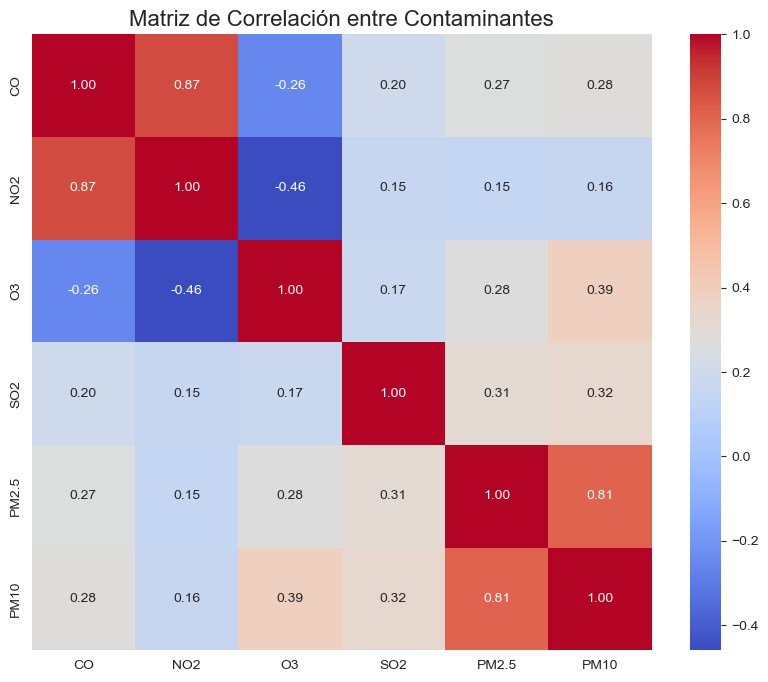

In [29]:
# Matriz de Correlación y Heatmap

# Solo columnas numéricas para el cálculo 
columnasNumericas = ['CO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10']
contaminantesNumericos = contaminantes[columnasNumericas]

# Matriz de correlacion
matrizCorrelacion = contaminantesNumericos.corr()

# Heatmap para la representacion de la matriz de correlacion    
plt.figure(figsize=(10, 8))
sns.heatmap(matrizCorrelacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Contaminantes', fontsize=16)
plt.savefig('../Images/matrizCorrelacion.png', dpi=300, bbox_inches='tight')
plt.show()


El mapa de calor anterior es una de las herramientas más importantes de nuestro análisis exploratorio. Su función principal en este proyecto es la de **guiar la selección de características (features)** para los modelos de regresión que construiremos en la Fase 2.

**¿Por qué?**
* **Para predecir PM2.5 y PM10:** Podemos observar que `PM2.5` y `PM10` tienen una **correlación positiva muy fuerte (0.81)**. También vemos correlaciones positivas moderadas con `SO2`. Esto nos sugiere que estas variables serán buenos predictores.
* **Para predecir Ozono (O3):** Notamos una **correlación negativa significativa (-0.46) entre `O3` y `NO2`**.El heatmap la confirma en nuestros datos, señalando al `NO2` como un predictor clave.

E heatmap valida nuestras hipótesis y nos da una base cuantitativa para elegir las variables de entrada más prometedoras para nuestros modelos.

## <a id="fase-2"></a>2. Fase 2: Modelado Predictivo (Regresión)

Ahora que vimos las relaciones entre nuestros datos, comenzaremos a construir el modelo. Primer bjetivo: predecir la concentración de partículas `PM2.5` y `PM10`.

### <a id="2-1"></a>2.1. Modelo 1: Predicción de Partículas PM2.5

Para ilustrar el concepto, comenzaremos con el caso más simple: una **regresión lineal simple** para predecir la concentración de `PM2.5` usando únicamente la variable con la que tiene mayor correlación: `PM10`. Luego, visualizaremos el resultado.

✅ Modelo de Regresión Lineal entrenado.


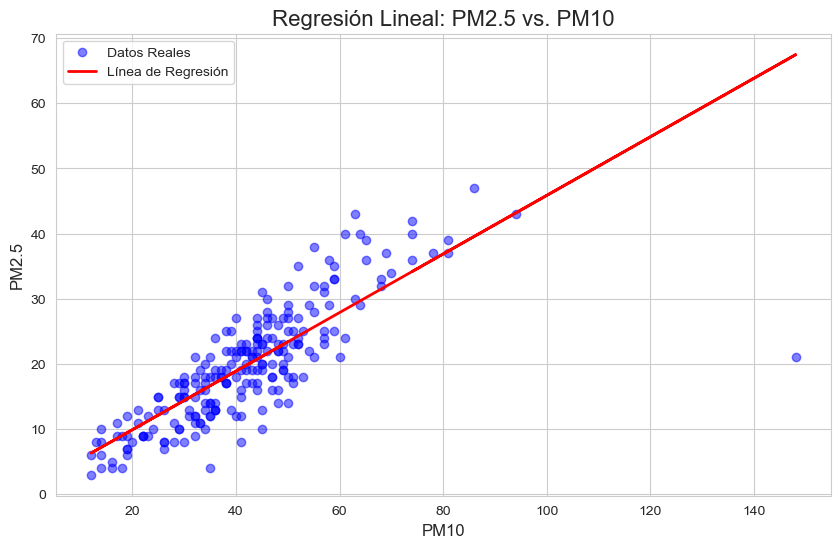

In [33]:
# Regresión Lineal Simple: PM10 -> PM2.5

# Selección de Características (X) y Objetivo (y)
# Doble corchete en X para mantenerlo como un DataFrame
X = contaminantes[['PM10']] 
y = contaminantes['PM2.5']

# Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelado
modeloLineal = LinearRegression()
modeloLineal.fit(X_train, y_train)
print("✅ Modelo de Regresión Lineal entrenado.")

# Predicciones
y_pred = modeloLineal.predict(X_test)

# Evaluación del Modelo
plt.figure(figsize=(10, 6))

# Visualización de los resultados
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Datos Reales')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Línea de Regresión')

plt.title('Regresión Lineal: PM2.5 vs. PM10', fontsize=16)
plt.xlabel('PM10', fontsize=12)
plt.ylabel('PM2.5', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### Justificación del Método: La API de Scikit-Learn
La imagen a continuación muestra la "firma" del método `.fit()`.


![Firma del método .fit() de Scikit-learn](../Images/parametrosRLineal.png)

Como indica la documentación, el método espera dos argumentos principales:
* **`X`**: Un arreglo o matriz con las características de entrada (en nuestro caso, `X_train`).
* **`y`**: Un arreglo con los valores objetivo correspondientes (en nuestro caso, `y_train`).

**Referencia:** [Documentación Oficial de LinearRegression en scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)